# Style Transfer Crash Course
## Bornhack 2019

### Import libraries

In [1]:
import tensorflow as tf
from tensorflow.python.keras.preprocessing import image as kp_image

# Keras is only used to load VGG19 model as a high level API to TensorFlow 
from keras.applications.vgg19 import VGG19
from keras.models import Model
from keras import backend as K

# image functions
from PIL import Image
from IPython.core.display import HTML, display, Image as DisplayImage

# numPy is used for manipulation of array of object i.e Image in our case
import numpy as np

Using TensorFlow backend.


In [2]:
from style_transfer import load_img, deprocess_img

##### Confirm virtual environment

In [3]:
!python --version

Python 3.7.0


In [4]:
!pip freeze

absl-py==0.7.1
appnope==0.1.0
astor==0.8.0
astroid==2.2.5
attrs==19.1.0
backcall==0.1.0
bleach==3.1.0
cycler==0.10.0
decorator==4.4.0
defusedxml==0.6.0
entrypoints==0.3
gast==0.2.2
google-pasta==0.1.7
grpcio==1.22.0
h5py==2.9.0
ipykernel==5.1.1
ipython==7.6.1
ipython-genutils==0.2.0
isort==4.3.21
jedi==0.14.1
Jinja2==2.10.1
json5==0.8.5
jsonschema==3.0.1
jupyter-client==5.3.1
jupyter-core==4.5.0
jupyterlab==1.0.2
jupyterlab-server==1.0.0
Keras==2.2.4
Keras-Applications==1.0.8
Keras-Preprocessing==1.1.0
kiwisolver==1.1.0
lazy-object-proxy==1.4.1
Markdown==3.1.1
MarkupSafe==1.1.1
matplotlib==3.1.1
mccabe==0.6.1
mistune==0.8.4
nbconvert==5.5.0
nbformat==4.4.0
notebook==6.0.0
numpy==1.16.4
pandocfilters==1.4.2
parso==0.5.1
pexpect==4.7.0
pickleshare==0.7.5
Pillow==6.1.0
prometheus-client==0.7.1
prompt-toolkit==2.0.9
protobuf==3.9.0
ptyprocess==0.6.0
Pygments==2.4.2
pylint==2.3.1
pyparsing==2.4.2
pyrsistent==0.15.3
python-dateutil==2.8.0
PyYAML==5.1.1
pyzmq==18.0.2
scipy==1.3.0
Send2Trash==

##### Visualization Functions 

In [5]:
def display_side_to_side_two(path1, path2, width=300, height=400):
    display(HTML("<table><tr><td><img src='{0}' width={2} height={3}></td><td><img src='{1}' width={2} height={3}></td></tr></table>".format(path1, path2, width, height)))
    
def display_side_to_side_three(path1, path2, path3, width=300, height=400):
    display(HTML("<table><tr><td><img src='{0}' width={3} height={4}></td><td><img src='{1}' width={3} height={4}></td><td><img src='{2}' width={3} height={4}></td></tr></table>".format(path1, path2, path3, width, height)))

### Config 
We need to define a couple of key parameters ahead of time.

##### Input images for content and style

In [6]:
# path where the content and style images are located
content_path = 'data/contents/content-horseduck.jpg'
style_path = 'data/styles/style-dali-2.jpg'

Quick visual inspection.

In [7]:
display_side_to_side_two(content_path, style_path, width=400)

,


In [8]:
# path to where Vgg19 model weight is located 
vgg_weights = "data/vgg_weights/vgg19_weights_tf_dim_ordering_tf_kernels_notop.h5"

##### Output generated image

In [9]:
# save the result as
save_name = 'generated.jpg'

#####  ML parameters

In [10]:
num_iterations = 200
content_weight = 0.1
style_weight = 0.9

##### Other

In [11]:
# list of layers to be considered for calculation of Content and Style Loss
content_layers = ['block3_conv3']
style_layers = ['block1_conv1','block2_conv2','block4_conv3']

num_content_layers = len(content_layers)
num_style_layers = len(style_layers)

### Visual Investigation

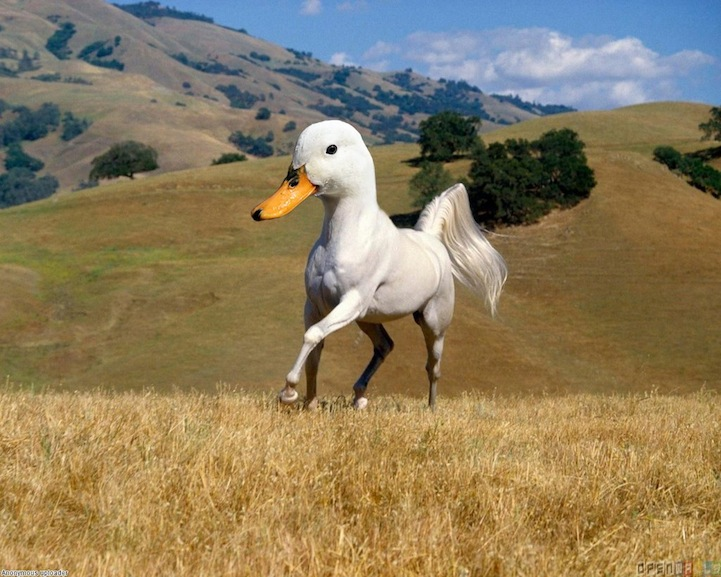

In [12]:
display(DisplayImage(content_path, width=400))

In [13]:
display_side_to_side_two(content_path, style_path, width=400)

,


### Loss Functions

##### Get Features

In [14]:
def get_feature_representations(model, content_path, style_path, num_content_layers):
    """
    Used to pass content and style image through the model.
    """

    # Load our images in 
    content_image = load_img(content_path)
    style_image   = load_img(style_path)

    # batch compute content and style features
    content_outputs = model(content_image)
    style_outputs   = model(style_image)

    # Get the style and content feature representations from our model  
    style_features   = [ style_layer[0]  for style_layer    in style_outputs[num_content_layers:] ]
    content_features = [ content_layer[0] for content_layer in content_outputs[:num_content_layers] ]

    return style_features, content_features

##### Content Loss

In [15]:
def get_content_loss(content, target):
    return tf.reduce_mean(tf.square(content - target)) /2

##### Style Loss

In [16]:
def get_style_loss(base_style, gram_target):

    height, width, channels = base_style.get_shape().as_list()
    gram_style = gram_matrix(base_style)

    # Original eqn as a constant to divide i.e 1/(4. * (channels ** 2) * (width * height) ** 2)
    return tf.reduce_mean(tf.square(gram_style - gram_target)) / (channels**2 * width * height) #(4.0 * (channels ** 2) * (width * height) ** 2)

##### Gram Matrix

In [17]:
def gram_matrix(input_tensor):

    # if input tensor is a 3D array of size Nh x Nw X Nc
    # we reshape it to a 2D array of Nc x (Nh*Nw)
    channels = int(input_tensor.shape[-1])
    a = tf.reshape(input_tensor, [-1, channels])
    n = tf.shape(a)[0]

    # get gram matrix 
    gram = tf.matmul(a, a, transpose_a=True)

    return gram

##### Combine Losses

In [18]:
def compute_loss(model, loss_weights, generated_output_activations, 
                 gram_style_features, content_features, 
                 num_content_layers, num_style_layers):

    generated_content_activations = generated_output_activations[:num_content_layers]
    generated_style_activations   = generated_output_activations[num_content_layers:]

    style_weight, content_weight = loss_weights

    style_score = 0
    content_score = 0

    # Accumulate style losses from all layers
    # Here, we equally weight each contribution of each loss layer
    weight_per_style_layer = 1.0 / float(num_style_layers)
    for target_style, comb_style in zip(gram_style_features, generated_style_activations):
        temp = get_style_loss(comb_style[0], target_style)
        style_score += weight_per_style_layer * temp

    # Accumulate content losses from all layers 
    weight_per_content_layer = 1.0 / float(num_content_layers)
    for target_content, comb_content in zip(content_features, generated_content_activations):
        temp = get_content_loss(comb_content[0], target_content)
        content_score += weight_per_content_layer* temp

    # Get total loss
    loss = style_weight*style_score + content_weight*content_score 


    return loss, style_score, content_score

### Model 

In [19]:
# Using Keras Load VGG19 model
def get_model(content_layers,style_layers):

    # Load our model. We load pretrained VGG, trained on imagenet data
    vgg19 = VGG19(weights=None, include_top=False)

    # We don't need to (or want to) train any layers of our pre-trained vgg model, so we set it's trainable to false.
    vgg19.trainable = False

    style_model_outputs = [vgg19.get_layer(name).output for name in style_layers]
    content_model_outputs = [vgg19.get_layer(name).output for name in content_layers]

    model_outputs = content_model_outputs + style_model_outputs

    # Build model 
    return Model(inputs = vgg19.input, outputs = model_outputs),  vgg19

### Style Transfer

##### Start a session

In [20]:
# Create a tensorflow session 
sess = tf.Session()

# Assign keras back-end to the TF session which we created
K.set_session(sess)

##### Obtain the model

In [21]:
model, vgg19 = get_model(content_layers,style_layers)

W0804 19:00:13.321584 4533851584 deprecation_wrapper.py:119] From /Users/mateuszjurewicz/Bornhack ML Crashcourse/bornhack_ml_crashcourse/venv/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0804 19:00:13.323088 4533851584 deprecation_wrapper.py:119] From /Users/mateuszjurewicz/Bornhack ML Crashcourse/bornhack_ml_crashcourse/venv/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0804 19:00:13.327296 4533851584 deprecation_wrapper.py:119] From /Users/mateuszjurewicz/Bornhack ML Crashcourse/bornhack_ml_crashcourse/venv/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0804 19:00:13.359419 4533851584 deprecation_wrapper.py:119] From /Users/mateuszjurewicz/Bornhack ML Cra

#####  Get the style

In [22]:
# Get the style and content feature representations (from our specified intermediate layers) 
style_features, content_features = get_feature_representations(model, content_path, style_path, num_content_layers)
gram_style_features = [gram_matrix(style_feature) for style_feature in style_features]

##### Normalization

In [23]:
# VGG default normalization
norm_means = np.array([103.939, 116.779, 123.68])
min_vals = -norm_means
max_vals = 255 - norm_means 

##### TF variable for generated image

In [24]:
# load the original content image, as it will become the generated one
generated_image = load_img(content_path)

# create tensorflow variable to hold a stylized/generated image during the training 
generated_image = tf.Variable(generated_image, dtype=tf.float32)

# pass it to the model
model_outputs = model(generated_image)

##### Losses & Optimizer

In [25]:
# weightages of each content and style images i.e alpha & beta
loss_weights = (style_weight, content_weight)

In [26]:
# Create our optimizer
loss = compute_loss(model, loss_weights, model_outputs, gram_style_features, content_features, num_content_layers, num_style_layers)
opt = tf.train.AdamOptimizer(learning_rate=9, beta1=0.9, epsilon=1e-1).minimize( loss[0], var_list = [generated_image])

##### Initialize the TF variables

In [27]:
sess.run(tf.global_variables_initializer())
sess.run(generated_image.initializer)

##### Load the downloaded vgg19 weights

In [28]:
# loading the weights again because tf.global_variables_initializer() resets the weights
vgg19.load_weights(vgg_weights)

W0804 19:00:14.427534 4533851584 deprecation_wrapper.py:119] From /Users/mateuszjurewicz/Bornhack ML Crashcourse/bornhack_ml_crashcourse/venv/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:174: The name tf.get_default_session is deprecated. Please use tf.compat.v1.get_default_session instead.

W0804 19:00:14.428642 4533851584 deprecation_wrapper.py:119] From /Users/mateuszjurewicz/Bornhack ML Crashcourse/bornhack_ml_crashcourse/venv/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:190: The name tf.global_variables is deprecated. Please use tf.compat.v1.global_variables instead.



In [29]:
# Put loss as infinity before training starts and Create a variable to hold best image (i.e image with minimum loss)
best_loss, best_img = float('inf'), None

### Main Training Loop

In [30]:
for i in range(num_iterations):

    # Do optimization
    sess.run(opt)

    # Make sure image values stays in the range of max-min value of VGG norm 
    clipped = tf.clip_by_value(generated_image, min_vals, max_vals)
    # assign the clipped value to the tensor stylized image
    generated_image.assign(clipped)


    # Open the Tuple of tensors 
    total_loss, style_score, content_score = loss
    total_loss = total_loss.eval(session=sess)


    if total_loss < best_loss:

        # Update best loss and best image from total loss. 
        best_loss = total_loss

        # generated image is of shape (1, h, w, 3) convert it to (h, w, 3)
        temp_generated_image = sess.run(generated_image)[0]
        best_img = deprocess_img(temp_generated_image)

        s_loss = sess.run(style_score)
        c_loss = sess.run(content_score)

        # print best loss
        print('best: iteration: ', i ,'loss: ', total_loss ,'  style_loss: ',  s_loss,'  content_loss: ', c_loss)

    # Save image after every X iterations 
    if (i+1)%10 == 0:
        output = Image.fromarray(best_img)
        output.save(str(i+1)+'-'+save_name)
        
        # show
        display_side_to_side_three(content_path, style_path, str(i+1)+'-'+save_name)

# after num_iterations iterations are completed, close the TF session 
sess.close()

best: iteration:  0 loss:  105032220.0   style_loss:  116700760.0   content_loss:  15529.515
best: iteration:  1 loss:  87701464.0   style_loss:  97442050.0   content_loss:  36254.582
best: iteration:  2 loss:  71090424.0   style_loss:  78984856.0   content_loss:  40579.426
best: iteration:  3 loss:  44052204.0   style_loss:  48942812.0   content_loss:  36777.074
best: iteration:  4 loss:  33068930.0   style_loss:  36739524.0   content_loss:  33553.03
best: iteration:  5 loss:  30238526.0   style_loss:  33594604.0   content_loss:  33834.605
best: iteration:  6 loss:  27061448.0   style_loss:  30064154.0   content_loss:  37098.72
best: iteration:  7 loss:  23997846.0   style_loss:  26659664.0   content_loss:  41492.68
best: iteration:  8 loss:  21487924.0   style_loss:  23870480.0   content_loss:  44920.207
best: iteration:  9 loss:  18525046.0   style_loss:  20578230.0   content_loss:  46397.99


,,


best: iteration:  10 loss:  15616094.0   style_loss:  17346056.0   content_loss:  46437.055
best: iteration:  11 loss:  13643818.0   style_loss:  15154680.0   content_loss:  46055.312
best: iteration:  12 loss:  12387738.0   style_loss:  13759032.0   content_loss:  46092.285
best: iteration:  13 loss:  11252191.0   style_loss:  12497234.0   content_loss:  46795.16
best: iteration:  14 loss:  10143765.0   style_loss:  11265524.0   content_loss:  47939.746
best: iteration:  15 loss:  9299039.0   style_loss:  10326809.0   content_loss:  49109.465
best: iteration:  16 loss:  8707573.0   style_loss:  9669536.0   content_loss:  49910.08
best: iteration:  17 loss:  8113713.5   style_loss:  9009661.0   content_loss:  50190.582
best: iteration:  18 loss:  7459616.0   style_loss:  8282897.0   content_loss:  50092.9
best: iteration:  19 loss:  6896301.5   style_loss:  7657002.0   content_loss:  50001.65


,,


best: iteration:  20 loss:  6461502.0   style_loss:  7173868.0   content_loss:  50208.33
best: iteration:  21 loss:  6077811.5   style_loss:  6747480.0   content_loss:  50787.79
best: iteration:  22 loss:  5716103.5   style_loss:  6345492.5   content_loss:  51603.273
best: iteration:  23 loss:  5388850.5   style_loss:  5981788.0   content_loss:  52413.61
best: iteration:  24 loss:  5085159.0   style_loss:  5644287.5   content_loss:  53006.688
best: iteration:  25 loss:  4799027.5   style_loss:  5326326.0   content_loss:  53339.824
best: iteration:  26 loss:  4549287.0   style_loss:  5048818.0   content_loss:  53517.5
best: iteration:  27 loss:  4334652.0   style_loss:  4810311.0   content_loss:  53720.812
best: iteration:  28 loss:  4121552.0   style_loss:  4573493.5   content_loss:  54075.465
best: iteration:  29 loss:  3899962.2   style_loss:  4327225.0   content_loss:  54597.75


,,


best: iteration:  30 loss:  3700195.8   style_loss:  4105196.0   content_loss:  55196.176
best: iteration:  31 loss:  3538995.2   style_loss:  3926024.2   content_loss:  55734.55
best: iteration:  32 loss:  3396790.2   style_loss:  3767976.5   content_loss:  56115.94
best: iteration:  33 loss:  3255387.5   style_loss:  3610837.0   content_loss:  56343.438
best: iteration:  34 loss:  3120582.2   style_loss:  3461032.8   content_loss:  56526.87
best: iteration:  35 loss:  2996683.0   style_loss:  3323338.8   content_loss:  56783.59
best: iteration:  36 loss:  2879098.5   style_loss:  3192646.5   content_loss:  57166.29
best: iteration:  37 loss:  2769390.0   style_loss:  3070696.8   content_loss:  57629.254
best: iteration:  38 loss:  2670209.8   style_loss:  2960447.8   content_loss:  58067.535
best: iteration:  39 loss:  2575833.0   style_loss:  2855547.5   content_loss:  58402.37


,,


best: iteration:  40 loss:  2483974.8   style_loss:  2753457.2   content_loss:  58631.83
best: iteration:  41 loss:  2400469.0   style_loss:  2660652.8   content_loss:  58814.445
best: iteration:  42 loss:  2325316.8   style_loss:  2577127.0   content_loss:  59025.805
best: iteration:  43 loss:  2251700.5   style_loss:  2495300.2   content_loss:  59302.156
best: iteration:  44 loss:  2178801.5   style_loss:  2414266.5   content_loss:  59618.18
best: iteration:  45 loss:  2111058.5   style_loss:  2338963.5   content_loss:  59914.266
best: iteration:  46 loss:  2048634.1   style_loss:  2269577.8   content_loss:  60142.57
best: iteration:  47 loss:  1990086.4   style_loss:  2204506.8   content_loss:  60303.574
best: iteration:  48 loss:  1936054.6   style_loss:  2144456.8   content_loss:  60436.555
best: iteration:  49 loss:  1885152.8   style_loss:  2087881.6   content_loss:  60594.094


,,


best: iteration:  50 loss:  1835002.4   style_loss:  2032135.8   content_loss:  60802.01
best: iteration:  51 loss:  1786982.1   style_loss:  1978753.6   content_loss:  61040.44
best: iteration:  52 loss:  1742726.5   style_loss:  1929556.5   content_loss:  61257.766
best: iteration:  53 loss:  1700741.0   style_loss:  1882888.8   content_loss:  61411.152
best: iteration:  54 loss:  1660291.8   style_loss:  1837934.8   content_loss:  61505.117
best: iteration:  55 loss:  1622071.1   style_loss:  1795458.8   content_loss:  61583.062
best: iteration:  56 loss:  1585566.0   style_loss:  1754885.0   content_loss:  61695.582
best: iteration:  57 loss:  1550321.8   style_loss:  1715706.9   content_loss:  61857.418
best: iteration:  58 loss:  1517135.6   style_loss:  1678813.1   content_loss:  62039.035
best: iteration:  59 loss:  1485604.4   style_loss:  1643760.8   content_loss:  62196.92


,,


best: iteration:  60 loss:  1454840.1   style_loss:  1609566.0   content_loss:  62304.734
best: iteration:  61 loss:  1425379.0   style_loss:  1576824.0   content_loss:  62375.39
best: iteration:  62 loss:  1397528.9   style_loss:  1545871.8   content_loss:  62443.44
best: iteration:  63 loss:  1370629.6   style_loss:  1515973.5   content_loss:  62533.754
best: iteration:  64 loss:  1344605.9   style_loss:  1487046.1   content_loss:  62642.344
best: iteration:  65 loss:  1319785.0   style_loss:  1459455.9   content_loss:  62748.65
best: iteration:  66 loss:  1295907.9   style_loss:  1432916.1   content_loss:  62833.188
best: iteration:  67 loss:  1272937.6   style_loss:  1407386.6   content_loss:  62897.44
best: iteration:  68 loss:  1251001.2   style_loss:  1383005.8   content_loss:  62961.27
best: iteration:  69 loss:  1229724.4   style_loss:  1359356.0   content_loss:  63041.676


,,


best: iteration:  70 loss:  1209047.2   style_loss:  1336370.9   content_loss:  63135.406
best: iteration:  71 loss:  1189239.2   style_loss:  1314352.2   content_loss:  63222.71
best: iteration:  72 loss:  1170176.2   style_loss:  1293164.1   content_loss:  63285.65
best: iteration:  73 loss:  1151701.6   style_loss:  1272632.2   content_loss:  63327.49
best: iteration:  74 loss:  1133889.1   style_loss:  1252835.9   content_loss:  63368.785
best: iteration:  75 loss:  1116611.2   style_loss:  1233631.2   content_loss:  63431.44
best: iteration:  76 loss:  1099774.6   style_loss:  1214914.6   content_loss:  63515.21
best: iteration:  77 loss:  1083530.1   style_loss:  1196855.8   content_loss:  63600.402
best: iteration:  78 loss:  1067853.1   style_loss:  1179429.2   content_loss:  63668.387
best: iteration:  79 loss:  1052624.5   style_loss:  1162503.2   content_loss:  63716.598


,,


best: iteration:  80 loss:  1037884.3   style_loss:  1146120.8   content_loss:  63756.805
best: iteration:  81 loss:  1023598.25   style_loss:  1130242.1   content_loss:  63803.812
best: iteration:  82 loss:  1009667.5   style_loss:  1114756.9   content_loss:  63863.383
best: iteration:  83 loss:  996117.1   style_loss:  1099693.5   content_loss:  63930.062
best: iteration:  84 loss:  982949.56   style_loss:  1085055.8   content_loss:  63994.273
best: iteration:  85 loss:  970114.25   style_loss:  1070788.0   content_loss:  64050.83
best: iteration:  86 loss:  957639.7   style_loss:  1056921.6   content_loss:  64102.72
best: iteration:  87 loss:  945508.44   style_loss:  1043436.5   content_loss:  64155.96
best: iteration:  88 loss:  933662.4   style_loss:  1030267.75   content_loss:  64213.832
best: iteration:  89 loss:  922135.6   style_loss:  1017453.9   content_loss:  64272.04


,,


best: iteration:  90 loss:  910919.4   style_loss:  1004985.6   content_loss:  64323.74
best: iteration:  91 loss:  899989.3   style_loss:  992836.1   content_loss:  64367.957
best: iteration:  92 loss:  889331.56   style_loss:  980989.25   content_loss:  64412.37
best: iteration:  93 loss:  878901.4   style_loss:  969394.6   content_loss:  64462.438
best: iteration:  94 loss:  868714.1   style_loss:  958069.4   content_loss:  64516.844
best: iteration:  95 loss:  858775.44   style_loss:  947020.6   content_loss:  64568.73
best: iteration:  96 loss:  849072.8   style_loss:  936235.0   content_loss:  64613.0
best: iteration:  97 loss:  839605.94   style_loss:  925712.0   content_loss:  64652.05
best: iteration:  98 loss:  830353.75   style_loss:  915427.4   content_loss:  64691.324
best: iteration:  99 loss:  821299.5   style_loss:  905362.25   content_loss:  64734.863


,,


best: iteration:  100 loss:  812445.8   style_loss:  895519.5   content_loss:  64783.133
best: iteration:  101 loss:  803783.0   style_loss:  885888.75   content_loss:  64831.332
best: iteration:  102 loss:  795300.8   style_loss:  876459.1   content_loss:  64876.15
best: iteration:  103 loss:  786995.1   style_loss:  867225.75   content_loss:  64918.805
best: iteration:  104 loss:  778857.5   style_loss:  858179.25   content_loss:  64962.39
best: iteration:  105 loss:  770881.06   style_loss:  849311.4   content_loss:  65008.477
best: iteration:  106 loss:  763064.6   style_loss:  840621.3   content_loss:  65054.844
best: iteration:  107 loss:  755406.2   style_loss:  832107.0   content_loss:  65098.188
best: iteration:  108 loss:  747904.25   style_loss:  823767.0   content_loss:  65139.477
best: iteration:  109 loss:  740553.6   style_loss:  815594.94   content_loss:  65182.3


,,


best: iteration:  110 loss:  733358.2   style_loss:  807594.94   content_loss:  65227.71
best: iteration:  111 loss:  726309.2   style_loss:  799757.5   content_loss:  65274.098
best: iteration:  112 loss:  719387.25   style_loss:  792061.44   content_loss:  65319.94
best: iteration:  113 loss:  712586.44   style_loss:  784500.1   content_loss:  65363.254
best: iteration:  114 loss:  705912.56   style_loss:  777080.1   content_loss:  65404.56
best: iteration:  115 loss:  699370.44   style_loss:  769806.5   content_loss:  65446.0
best: iteration:  116 loss:  692949.94   style_loss:  762668.0   content_loss:  65487.8
best: iteration:  117 loss:  686639.9   style_loss:  755652.4   content_loss:  65528.246
best: iteration:  118 loss:  680440.0   style_loss:  748759.2   content_loss:  65567.37
best: iteration:  119 loss:  674348.44   style_loss:  741986.5   content_loss:  65606.7


,,


best: iteration:  120 loss:  668370.25   style_loss:  735339.6   content_loss:  65646.54
best: iteration:  121 loss:  662496.8   style_loss:  728809.2   content_loss:  65685.9
best: iteration:  122 loss:  656729.9   style_loss:  722397.25   content_loss:  65724.27
best: iteration:  123 loss:  651060.2   style_loss:  716093.25   content_loss:  65762.45
best: iteration:  124 loss:  645482.1   style_loss:  709891.3   content_loss:  65799.664
best: iteration:  125 loss:  639993.4   style_loss:  703788.6   content_loss:  65836.4
best: iteration:  126 loss:  634588.8   style_loss:  697779.4   content_loss:  65873.914
best: iteration:  127 loss:  629271.5   style_loss:  691866.9   content_loss:  65913.266
best: iteration:  128 loss:  624037.94   style_loss:  686047.44   content_loss:  65952.79
best: iteration:  129 loss:  618887.5   style_loss:  680320.5   content_loss:  65990.414


,,


best: iteration:  130 loss:  613817.06   style_loss:  674682.5   content_loss:  66027.27
best: iteration:  131 loss:  608826.44   style_loss:  669133.44   content_loss:  66063.66
best: iteration:  132 loss:  603914.06   style_loss:  663671.25   content_loss:  66099.68
best: iteration:  133 loss:  599080.75   style_loss:  658296.9   content_loss:  66135.695
best: iteration:  134 loss:  594320.44   style_loss:  653003.5   content_loss:  66172.89
best: iteration:  135 loss:  589634.56   style_loss:  647792.8   content_loss:  66210.32
best: iteration:  136 loss:  585024.3   style_loss:  642666.2   content_loss:  66247.39
best: iteration:  137 loss:  580480.06   style_loss:  637612.9   content_loss:  66285.19
best: iteration:  138 loss:  576002.8   style_loss:  632633.94   content_loss:  66323.03
best: iteration:  139 loss:  571589.0   style_loss:  627725.56   content_loss:  66360.07


,,


best: iteration:  140 loss:  567241.3   style_loss:  622890.8   content_loss:  66396.28
best: iteration:  141 loss:  562955.5   style_loss:  618124.75   content_loss:  66432.44
best: iteration:  142 loss:  558729.6   style_loss:  613425.4   content_loss:  66468.06
best: iteration:  143 loss:  554562.56   style_loss:  608791.44   content_loss:  66503.35
best: iteration:  144 loss:  550455.2   style_loss:  604223.7   content_loss:  66538.6
best: iteration:  145 loss:  546409.75   style_loss:  599724.8   content_loss:  66574.61
best: iteration:  146 loss:  542418.7   style_loss:  595286.4   content_loss:  66609.51
best: iteration:  147 loss:  538478.56   style_loss:  590904.8   content_loss:  66643.01
best: iteration:  148 loss:  534591.9   style_loss:  586582.5   content_loss:  66676.27
best: iteration:  149 loss:  530752.06   style_loss:  582312.2   content_loss:  66711.01


,,


best: iteration:  150 loss:  526964.2   style_loss:  578099.3   content_loss:  66747.664
best: iteration:  151 loss:  523231.25   style_loss:  573947.6   content_loss:  66784.64
best: iteration:  152 loss:  519556.0   style_loss:  569860.0   content_loss:  66819.95
best: iteration:  153 loss:  515934.75   style_loss:  565832.5   content_loss:  66854.914
best: iteration:  154 loss:  512366.34   style_loss:  561863.6   content_loss:  66891.02
best: iteration:  155 loss:  508845.4   style_loss:  557947.5   content_loss:  66926.56
best: iteration:  156 loss:  505374.47   style_loss:  554087.0   content_loss:  66961.31
best: iteration:  157 loss:  501950.2   style_loss:  550278.44   content_loss:  66995.9
best: iteration:  158 loss:  498574.0   style_loss:  546523.4   content_loss:  67029.72
best: iteration:  159 loss:  495244.47   style_loss:  542820.1   content_loss:  67063.8


,,


best: iteration:  160 loss:  491958.72   style_loss:  539165.4   content_loss:  67098.945
best: iteration:  161 loss:  488713.44   style_loss:  535555.6   content_loss:  67133.875
best: iteration:  162 loss:  485512.8   style_loss:  531995.7   content_loss:  67167.484
best: iteration:  163 loss:  482356.5   style_loss:  528484.9   content_loss:  67201.09
best: iteration:  164 loss:  479247.28   style_loss:  525026.4   content_loss:  67235.5
best: iteration:  165 loss:  476181.47   style_loss:  521616.2   content_loss:  67268.93
best: iteration:  166 loss:  473154.53   style_loss:  518249.25   content_loss:  67302.22
best: iteration:  167 loss:  470162.97   style_loss:  514921.5   content_loss:  67336.28
best: iteration:  168 loss:  467209.53   style_loss:  511636.12   content_loss:  67369.67
best: iteration:  169 loss:  464292.94   style_loss:  508391.97   content_loss:  67401.62


,,


best: iteration:  170 loss:  461409.44   style_loss:  505184.7   content_loss:  67432.11
best: iteration:  171 loss:  458559.4   style_loss:  502014.7   content_loss:  67462.01
best: iteration:  172 loss:  455747.12   style_loss:  498886.5   content_loss:  67492.96
best: iteration:  173 loss:  452967.78   style_loss:  495794.78   content_loss:  67525.14
best: iteration:  174 loss:  450220.47   style_loss:  492738.62   content_loss:  67557.42
best: iteration:  175 loss:  447504.9   style_loss:  489717.97   content_loss:  67587.414
best: iteration:  176 loss:  444820.22   style_loss:  486731.78   content_loss:  67616.15
best: iteration:  177 loss:  442167.06   style_loss:  483780.62   content_loss:  67645.1
best: iteration:  178 loss:  439544.72   style_loss:  480863.62   content_loss:  67674.805
best: iteration:  179 loss:  436953.56   style_loss:  477981.2   content_loss:  67704.9


,,


best: iteration:  180 loss:  434393.22   style_loss:  475133.06   content_loss:  67734.61
best: iteration:  181 loss:  431862.4   style_loss:  472317.8   content_loss:  67764.5
best: iteration:  182 loss:  429361.88   style_loss:  469536.0   content_loss:  67795.08
best: iteration:  183 loss:  426890.7   style_loss:  466786.8   content_loss:  67825.58
best: iteration:  184 loss:  424447.0   style_loss:  464068.28   content_loss:  67855.69
best: iteration:  185 loss:  422028.84   style_loss:  461378.12   content_loss:  67885.45
best: iteration:  186 loss:  419639.28   style_loss:  458719.84   content_loss:  67914.516
best: iteration:  187 loss:  417275.6   style_loss:  456090.22   content_loss:  67944.5
best: iteration:  188 loss:  414937.72   style_loss:  453489.06   content_loss:  67975.72
best: iteration:  189 loss:  412626.84   style_loss:  450918.12   content_loss:  68005.44


,,


best: iteration:  190 loss:  410342.5   style_loss:  448376.78   content_loss:  68033.76
best: iteration:  191 loss:  408085.3   style_loss:  445865.62   content_loss:  68062.414
best: iteration:  192 loss:  405853.8   style_loss:  443383.03   content_loss:  68090.86
best: iteration:  193 loss:  403642.38   style_loss:  440922.8   content_loss:  68118.44
best: iteration:  194 loss:  401455.4   style_loss:  438489.78   content_loss:  68146.195
best: iteration:  195 loss:  399293.84   style_loss:  436085.03   content_loss:  68173.26
best: iteration:  196 loss:  397154.25   style_loss:  433704.78   content_loss:  68200.03
best: iteration:  197 loss:  395036.38   style_loss:  431348.5   content_loss:  68227.5
best: iteration:  198 loss:  392938.94   style_loss:  429014.94   content_loss:  68254.97
best: iteration:  199 loss:  390860.75   style_loss:  426702.97   content_loss:  68281.4


,,


### Inspection

Show us the final images.

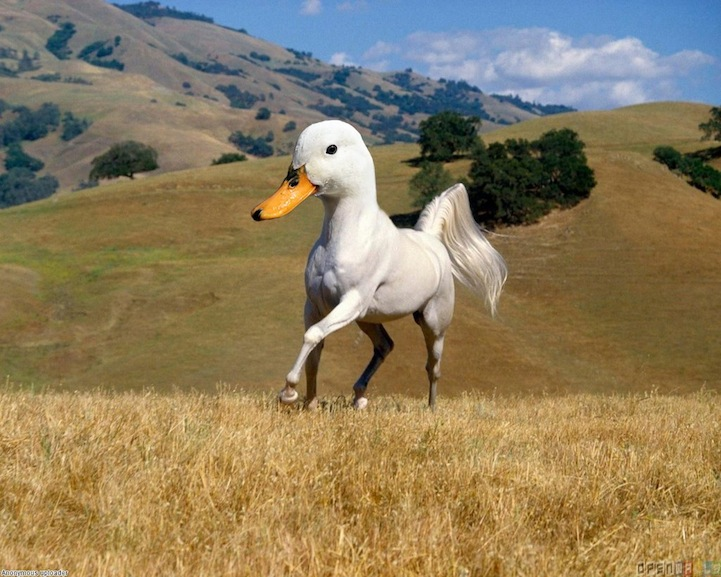

In [31]:
display(DisplayImage(content_path, width=600))

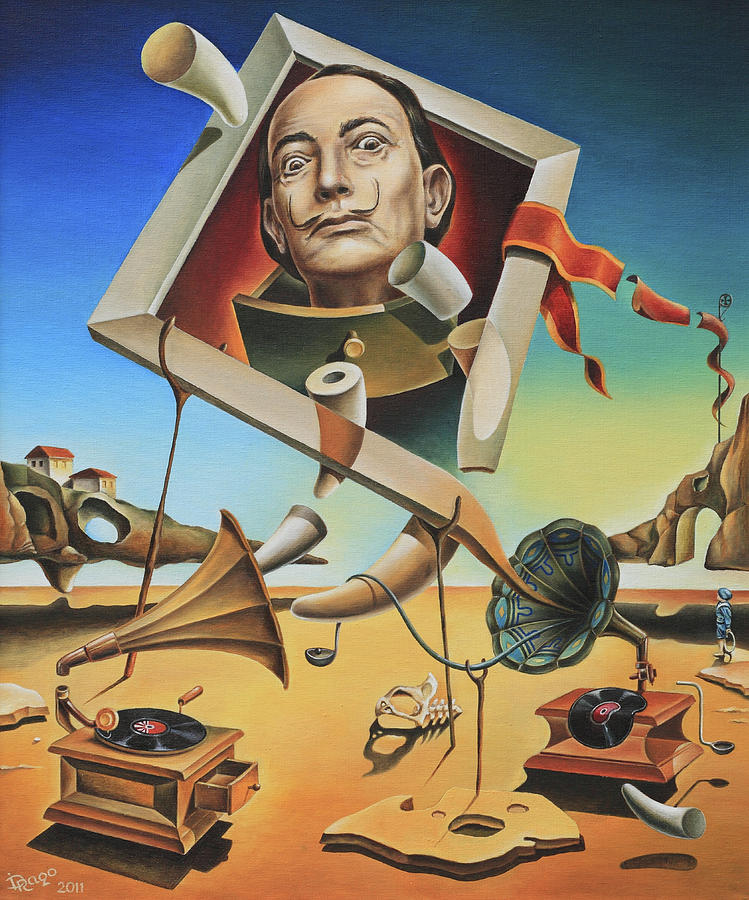

In [32]:
display(DisplayImage(style_path, width=600))

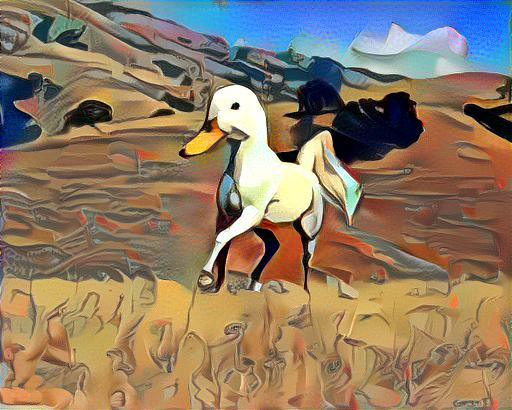

In [35]:
display(DisplayImage(str(200)+'-'+save_name, width=400))